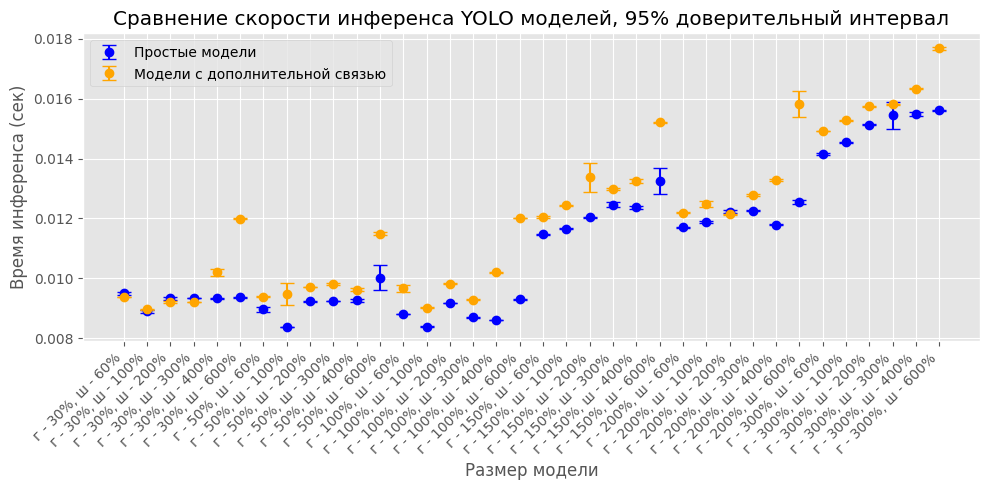

In [251]:
import time
import os
import re
import torch
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as T
from scipy import stats
from torchvision.models.detection import fasterrcnn_resnet50_fpn, ssd300_vgg16
from detection_model import ObjectDetectionModel
from collections import defaultdict
# –ë–∞–∑–æ–≤—ã–π —Ä–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏ YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """–ò–∑–≤–ª–µ–∫–∞–µ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä—ã depth –∏ width –∏–∑ –Ω–∞–∑–≤–∞–Ω–∏—è –ø–∞–ø–∫–∏ –≤ —Ñ–æ—Ä–º–∞—Ç–µ [depth_xx-width_xx] –∏ –ø–µ—Ä–µ–≤–æ–¥–∏—Ç –≤ —Ñ–æ—Ä–º–∞—Ç '–≥ - n%, —à - k%'"""
    extra_flag = 'base'
    if folder_name.startswith('extra_'):
        extra_flag = 'extra'
        folder_name = folder_name[6:] #—É–¥–∞–ª—è–µ–º extra_
    depth, width = folder_name.replace('[depth_', '').replace(']', '').replace('-width_', ' ').split(' ')
     
    depth, width = float(depth) , float(width)  
    # –ü–µ—Ä–µ–≤–æ–¥–∏–º –≤ –ø—Ä–æ—Ü–µ–Ω—Ç—ã –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –±–∞–∑–æ–≤–æ–≥–æ —Ä–∞–∑–º–µ—Ä–∞
    depth_percent = (depth / base_yolo_size[0]) * 100
    width_percent = (width / base_yolo_size[1]) * 100
    return extra_flag, f"–≥ - {int(depth_percent)}%, —à - {int(width_percent)}%" 
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # –ü–µ—Ä–µ–≤–æ–¥–∏–º –≤ –ø—Ä–æ—Ü–µ–Ω—Ç—ã –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –±–∞–∑–æ–≤–æ–≥–æ —Ä–∞–∑–º–µ—Ä–∞
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100

        return f"–≥ - {int(depth_percent)}%, —à - {int(width_percent)}%"
    return None

def measure_inference_time(model_path, image, num_runs=200, mode='yolo'):
    """–ò–∑–º–µ—Ä—è–µ—Ç –≤—Ä–µ–º—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞ –º–æ–¥–µ–ª–∏ YOLO, –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ø–∏—Å–æ–∫ –≤—Ä–µ–º–µ–Ω –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞"""
    if mode == 'yolo':
        model = YOLO(model_path)
        inference_times = []
        
        # –ü—Ä–æ–≥–æ–Ω—è–µ–º –∏–Ω—Ñ–µ—Ä–µ–Ω—Å num_runs —Ä–∞–∑
        for i in range(num_runs):
            start_time = time.time()
            _ = model(image.unsqueeze(0), verbose=False)  # –ó–∞–ø—É—Å–∫ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞
            end_time = time.time()

            if i > 0:  # –ü—Ä–æ–ø—É—Å–∫–∞–µ–º –ø–µ—Ä–≤—ã–π –∑–∞–ø—É—Å–∫
                inference_times.append(end_time - start_time)

        return inference_times  # –í–æ–∑–≤—Ä–∞—â–∞–µ–º –≤—Å–µ –≤—Ä–µ–º–µ–Ω–∞ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞

    inference_times = []
    for i in range(num_runs):
        start_time = time.time()
        _ = model_path([image])  # –ó–∞–ø—É—Å–∫ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞
        end_time = time.time()

        if i > 0:  # –ü—Ä–æ–ø—É—Å–∫–∞–µ–º –ø–µ—Ä–≤—ã–π –∑–∞–ø—É—Å–∫
            inference_times.append(end_time - start_time)

    return inference_times

def evaluate_models(logs_dir, image_path, num_runs=250, extra_measure = False):
    """–ü—Ä–æ–≤–µ—Ä—è–µ—Ç —Å–∫–æ—Ä–æ—Å—Ç—å –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –≤ logs_dir –∏ —Å—Ç—Ä–æ–∏—Ç –≥—Ä–∞—Ñ–∏–∫ —Å—Ä–∞–≤–Ω–µ–Ω–∏—è"""
    to_tensor = T.ToTensor()
    # –ó–∞–≥—Ä—É–∂–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
    image = Image.open(image_path).convert("RGB")
    image_custom = image.resize((576, 576)) 
    image_custom = to_tensor(image_custom) 
    #results = {} 
    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä—É–µ–º defaultdict —Å –≤–ª–æ–∂–µ–Ω–Ω—ã–º defaultdict
    results = defaultdict(lambda: defaultdict(dict))
    # –ü–µ—Ä–µ–±–∏—Ä–∞–µ–º –ø–∞–ø–∫–∏ —Å –º–æ–¥–µ–ª—è–º–∏
    for folder in sorted(os.listdir(logs_dir)):
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        
        extra_flag, model_name = extract_model_size(folder)
        if not model_name:
            continue  # –ü—Ä–æ–ø—É—Å–∫–∞–µ–º –ø–∞–ø–∫–∏ –±–µ–∑ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–≥–æ —Ñ–æ—Ä–º–∞—Ç–∞

        weights_path = os.path.join(folder_path, "weights", "best.pt")
        if os.path.exists(weights_path):
            # –ò–∑–º–µ—Ä—è–µ–º –∏–Ω—Ñ–µ—Ä–µ–Ω—Å –¥–ª—è –º–æ–¥–µ–ª–∏
            inference_times = measure_inference_time(weights_path, image_custom, num_runs) 
            # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª –¥–ª—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞
            confidence_interval = stats.t.interval(0.95, len(inference_times)-1, loc=np.mean(inference_times), scale=stats.sem(inference_times))
            
            results[model_name][extra_flag] = {
                'mean': np.mean(inference_times),
                'ci_lower': confidence_interval[0],
                'ci_upper': confidence_interval[1],
                'inference_times': inference_times
            }
    if extra_measure: 
        for model_path in [['../detection/logs/ssd300/checkpoints/epoch=16-val_mAP=0.4295.ckpt', ssd300_vgg16, 'SSD'], 
                           ['../detection/logs/mask_rcnn/checkpoints/epoch=05-val_mAP=0.3417.ckpt', fasterrcnn_resnet50_fpn, 'FasterRCNN']]: 
            # –ó–∞–≥—Ä—É–∂–∞–µ–º –º–æ–¥–µ–ª—å
            model = ObjectDetectionModel.load_from_checkpoint(model_path[0], 'cpu')
            model.eval() 
            inference_times = measure_inference_time(model, image_custom, num_runs, mode = 'not yolo')
            confidence_interval = stats.t.interval(0.95, len(inference_times)-1, loc=np.mean(inference_times), scale=stats.sem(inference_times))
            
            results[model_path[2]]['base'] = {
                'mean': np.mean(inference_times),
                'ci_lower': confidence_interval[0],
                'ci_upper': confidence_interval[1],
                'inference_times': inference_times
            }
            
            
            
              
    # –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞ —Å –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–º–∏ –∏–Ω—Ç–µ—Ä–≤–∞–ª–∞–º–∏
    fig, ax = plt.subplots(figsize=(10, 5))
    # –°—Ç–∏–ª—å –≥—Ä–∞—Ñ–∏–∫–∞
    plt.style.use("ggplot")   
    ax.set_title("–°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Å–∫–æ—Ä–æ—Å—Ç–∏ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞ YOLO –º–æ–¥–µ–ª–µ–π, 95% –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª")
    ax.set_xlabel("–†–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏")
    ax.set_ylabel("–í—Ä–µ–º—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞ (—Å–µ–∫)")

    # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è
    model_names = list(results.keys())
    #extra_model_names = list(results['extra'].keys())
    #mean_times = [results[model]['base']['mean'] for model in base_model_names]
    #ci_lowers = [results[model]['base']['ci_lower'] for model in base_model_names]
    #ci_uppers = [results[model]['base']['ci_upper'] for model in base_model_names]
    
    # –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –≥—Ä–∞—Ñ–∏–∫–∞
    x_pos = np.arange(len(model_names))  # –ü–æ–∑–∏—Ü–∏–∏ –ø–æ –æ—Å–∏ X –¥–ª—è –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏
    means_base = []  # –°–ø–∏—Å–æ–∫ —Å—Ä–µ–¥–Ω–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π –¥–ª—è base
    ci_lower_base = []  # –°–ø–∏—Å–æ–∫ –Ω–∏–∂–Ω–∏—Ö –≥—Ä–∞–Ω–∏—Ü –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω–æ–≥–æ –∏–Ω—Ç–µ—Ä–≤–∞–ª–∞ –¥–ª—è base
    ci_upper_base = []  # –°–ø–∏—Å–æ–∫ –≤–µ—Ä—Ö–Ω–∏—Ö –≥—Ä–∞–Ω–∏—Ü –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω–æ–≥–æ –∏–Ω—Ç–µ—Ä–≤–∞–ª–∞ –¥–ª—è base
    
    means_extra = []  # –°–ø–∏—Å–æ–∫ —Å—Ä–µ–¥–Ω–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π –¥–ª—è extra
    ci_lower_extra = []  # –°–ø–∏—Å–æ–∫ –Ω–∏–∂–Ω–∏—Ö –≥—Ä–∞–Ω–∏—Ü –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω–æ–≥–æ –∏–Ω—Ç–µ—Ä–≤–∞–ª–∞ –¥–ª—è extra
    ci_upper_extra = []  # –°–ø–∏—Å–æ–∫ –≤–µ—Ä—Ö–Ω–∏—Ö –≥—Ä–∞–Ω–∏—Ü –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω–æ–≥–æ –∏–Ω—Ç–µ—Ä–≤–∞–ª–∞ –¥–ª—è extra
    # –û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º –∫–∞–∂–¥—É—é –º–æ–¥–µ–ª—å
    for i, model_name in enumerate(model_names):
        # –ü—Ä–æ–≤–µ—Ä—è–µ–º, –µ—Å—Ç—å –ª–∏ –¥–∞–Ω–Ω—ã–µ –¥–ª—è base
        base_data = results[model_name].get('base', None)
        if base_data:
            means_base.append(base_data['mean'])
            ci_lower_base.append(base_data['ci_lower'])
            ci_upper_base.append(base_data['ci_upper'])

        # –ü—Ä–æ–≤–µ—Ä—è–µ–º, –µ—Å—Ç—å –ª–∏ –¥–∞–Ω–Ω—ã–µ –¥–ª—è extra
        extra_data = results[model_name].get('extra', None)
        if extra_data:
            means_extra.append(extra_data['mean'])
            ci_lower_extra.append(extra_data['ci_lower'])
            ci_upper_extra.append(extra_data['ci_upper'])

    # –°—Ç—Ä–æ–∏–º –≥—Ä–∞—Ñ–∏–∫ –¥–ª—è base
    ax.errorbar(x_pos, means_base, yerr=[np.array(means_base) - np.array(ci_lower_base), 
                                         np.array(ci_upper_base) - np.array(means_base)],
                fmt='o', label='–ü—Ä–æ—Å—Ç—ã–µ –º–æ–¥–µ–ª–∏', color='blue', capsize=5, linestyle='none')

    # –°—Ç—Ä–æ–∏–º –≥—Ä–∞—Ñ–∏–∫ –¥–ª—è extra, –µ—Å–ª–∏ –¥–∞–Ω–Ω—ã–µ –µ—Å—Ç—å
    if means_extra and not extra_measure:
        ax.errorbar(x_pos[:len(means_extra)], means_extra, yerr=[np.array(means_extra) - np.array(ci_lower_extra), 
                                               np.array(ci_upper_extra) - np.array(means_extra)],
                    fmt='o', label='–ú–æ–¥–µ–ª–∏ —Å –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ–π —Å–≤—è–∑—å—é', color='orange', capsize=5, linestyle='none')

    # –ù–∞—Å—Ç—Ä–æ–∏–º –æ—Å—å X
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')

    # –î–æ–±–∞–≤–ª—è–µ–º –ª–µ–≥–µ–Ω–¥—É
    ax.legend()
    
    
    
    
    # –°—Ç—Ä–æ–∏–º —Ç–æ—á–∫–∏ —Å –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–º –∏–Ω—Ç–µ—Ä–≤–∞–ª–æ–º
    #ax.errorbar(base_model_names, mean_times, yerr=[np.array(mean_times) - np.array(ci_lowers), np.array(ci_uppers) - np.array(mean_times)],
    #            fmt='o', color='b', capsize=5)
    #mean_times = [results[model]['extra']['mean'] for model in extra_model_names]
    #ci_lowers = [results[model]['extra']['ci_lower'] for model in extra_model_names]
    #ci_uppers = [results[model]['extra']['ci_upper'] for model in extra_model_names]
    # –°—Ç—Ä–æ–∏–º —Ç–æ—á–∫–∏ —Å –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–º –∏–Ω—Ç–µ—Ä–≤–∞–ª–æ–º
    #ax.errorbar(extra_model_names, mean_times, yerr=[np.array(mean_times) - np.array(ci_lowers), np.array(ci_uppers) - np.array(mean_times)],
    #            fmt='o', color='r', capsize=5) 
    # –ù–∞—Å—Ç—Ä–æ–∏–º –æ—Å—å X
    #ax.set_xticklabels(base_model_names, rotation=45, ha='right')
    
    # –ü–æ–∫–∞–∑–∞—Ç—å –≥—Ä–∞—Ñ–∏–∫
    plt.tight_layout()
    plt.show()

    # –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    #for model, data in results.items():
    #    print(f"{model}: {data['mean']:.4f} —Å–µ–∫, –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª: ({data['ci_lower']:.4f}, {data['ci_upper']:.4f})")

# –ü—É—Ç–∏
logs_dir = "../detection/logs/yolo11/"
image_path = "1.jpg"

# –ó–∞–ø—É—Å–∫
evaluate_models(logs_dir, image_path, num_runs=250, extra_measure = False)

/home/user/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/user/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weig

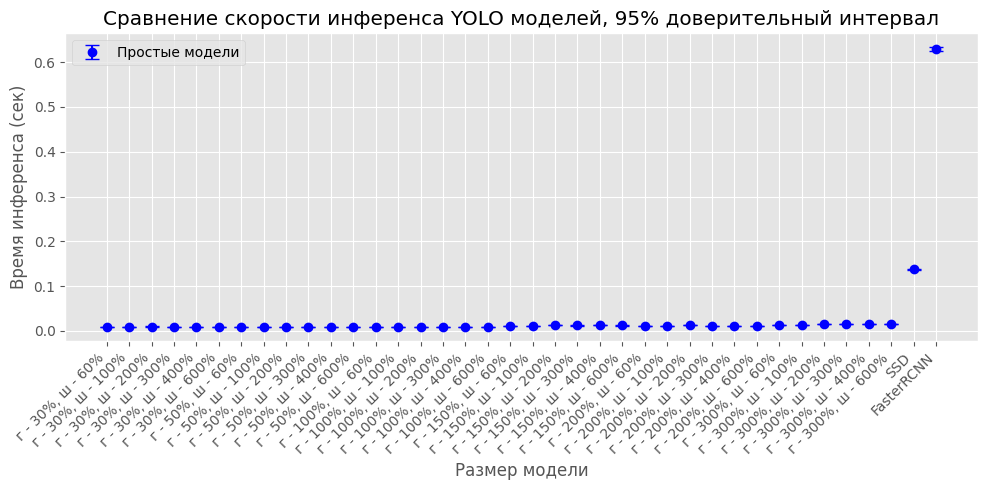

In [252]:
evaluate_models(logs_dir, image_path, num_runs=250, extra_measure = True)

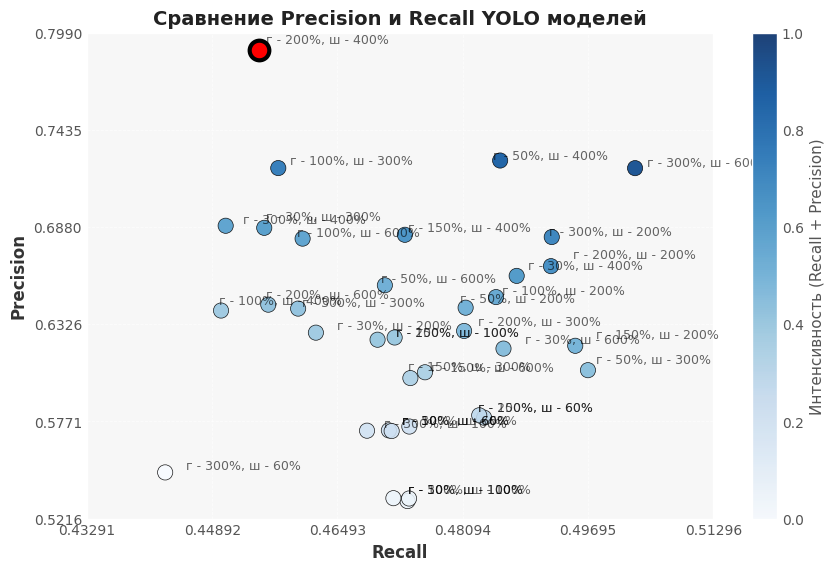

In [122]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# –ë–∞–∑–æ–≤—ã–π —Ä–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏ YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """–ò–∑–≤–ª–µ–∫–∞–µ—Ç depth –∏ width –∏–∑ –Ω–∞–∑–≤–∞–Ω–∏—è –ø–∞–ø–∫–∏ –≤ —Ñ–æ—Ä–º–∞—Ç–µ [depth_xx-width_xx] –∏ –ø–µ—Ä–µ–≤–æ–¥–∏—Ç –≤ —Ñ–æ—Ä–º–∞—Ç '–≥ - n%, —à - k%'"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # –ü–µ—Ä–µ–≤–æ–¥–∏–º –≤ –ø—Ä–æ—Ü–µ–Ω—Ç—ã –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –±–∞–∑–æ–≤–æ–≥–æ —Ä–∞–∑–º–µ—Ä–∞
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100

        return f"–≥ - {int(depth_percent)}%, —à - {int(width_percent)}%"
    return None

def get_max_metrics(csv_path):
    """–ò–∑–≤–ª–µ–∫–∞–µ—Ç –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–µ Precision –∏ Recall –∏–∑ results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_precision = df["metrics/precision(B)"].max()
        max_recall = df["metrics/recall(B)"].max()
        return max_precision, max_recall
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ –æ–±—Ä–∞–±–æ—Ç–∫–µ {csv_path}: {e}")
        return None, None

def evaluate_models(logs_dir):
    """–°–æ–±–∏—Ä–∞–µ—Ç Precision –∏ Recall –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –∏ —Å—Ç—Ä–æ–∏—Ç —É–ª—É—á—à–µ–Ω–Ω—ã–π –≥—Ä–∞—Ñ–∏–∫"""
    results = {}

    for folder in sorted(os.listdir(logs_dir)):
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        model_name = extract_model_size(folder)
        if not model_name:
            continue

        csv_path = os.path.join(folder_path, "results.csv")
        if os.path.exists(csv_path):
            max_precision, max_recall = get_max_metrics(csv_path)
            if max_precision is not None and max_recall is not None:
                results[model_name] = (max_precision, max_recall)

    # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞ —Ü–≤–µ—Ç–∞
    recalls = np.array([r[1] for r in results.values()])
    precisions = np.array([r[0] for r in results.values()])
    colors = recalls + precisions  # –ß–µ–º –≤—ã—à–µ recall + precision, —Ç–µ–º —è—Ä—á–µ —Ü–≤–µ—Ç
    norm_colors = (colors - colors.min()) / (colors.max() - colors.min())  # –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è

    # –î–æ–±–∞–≤–ª—è–µ–º jitter (—Ä–∞–∑–±—Ä–æ—Å) –¥–ª—è –∏–∑–±–µ–∂–∞–Ω–∏—è –Ω–∞–ª–æ–∂–µ–Ω–∏—è —Ç–æ—á–µ–∫
    jitter_strength = 0.002
    recalls += np.random.uniform(-jitter_strength, jitter_strength, size=len(recalls))
    precisions += np.random.uniform(-jitter_strength, jitter_strength, size=len(precisions))

    # –°—Ç–∏–ª—å –≥—Ä–∞—Ñ–∏–∫–∞
    plt.style.use("ggplot")  # –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ —Å—Ç–∏–ª—è seaborn-muted

    fig, ax = plt.subplots(figsize=(9, 6))
    scatter = ax.scatter(recalls, precisions, c=norm_colors, cmap="Blues", s=120, edgecolors="black", alpha=0.9)

    # –ù–∞–π–¥–µ–º —Ç–æ—á–∫—É —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–π —Å—É–º–º–æ–π (precision + recall)
    max_sum_index = np.argmax(precisions + recalls)  # –ò–Ω–¥–µ–∫—Å —Ç–æ—á–∫–∏ —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–π —Å—É–º–º–æ–π
    ax.scatter(recalls[max_sum_index], precisions[max_sum_index], c='red', s=200, edgecolors='black', linewidth=3, alpha=1)

    # –î–æ–±–∞–≤–ª—è–µ–º –ø–æ–¥–ø–∏—Å–∏ —Å –ø—Ä–æ–∑—Ä–∞—á–Ω–æ—Å—Ç—å—é —Ç–µ–∫—Å—Ç–∞
    for model, (precision, recall) in results.items():
        ax.text(recall + 0.001, precision + 0.001, model, fontsize=9, color = 'black',
                ha="left", va="bottom", alpha=0.6)

    # –î–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–π –º–∞—Å—à—Ç–∞–± –æ—Å–µ–π
    ax.set_xlim(max(0, min(recalls) - 0.01), min(1.05, max(recalls) + 0.01))
    ax.set_ylim(max(0, min(precisions) - 0.01), min(1.05, max(precisions) + 0.01))

    # –£–ª—É—á—à–∞–µ–º —Å—Ç–∏–ª—å –æ—Å–µ–π
    ax.set_xlabel("Recall", fontsize=12, fontweight="bold", color="#333")
    ax.set_ylabel("Precision", fontsize=12, fontweight="bold", color="#333")
    ax.set_title("–°—Ä–∞–≤–Ω–µ–Ω–∏–µ Precision –∏ Recall YOLO –º–æ–¥–µ–ª–µ–π", fontsize=14, fontweight="bold", color="#222")

    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 6))
    ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 6))

    # –£–ª—É—á—à–µ–Ω–Ω—ã–π —Ñ–æ–Ω –∏ —Å–µ—Ç–∫–∞
    ax.set_facecolor("#F7F7F7")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

    # –î–æ–±–∞–≤–ª—è–µ–º —Ü–≤–µ—Ç–æ–≤—É—é —à–∫–∞–ª—É
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("–ò–Ω—Ç–µ–Ω—Å–∏–≤–Ω–æ—Å—Ç—å (Recall + Precision)", fontsize=11)

    plt.show()

# –ü—É—Ç–∏
logs_dir = "../detection/logs/yolo11/"

# –ó–∞–ø—É—Å–∫
evaluate_models(logs_dir)


In [269]:
import math

def euclidean_distance_2d(point1, point2):
    """–í—ã—á–∏—Å–ª—è–µ—Ç –µ–≤–∫–ª–∏–¥–æ–≤–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –º–µ–∂–¥—É –¥–≤—É–º—è —Ç–æ—á–∫–∞–º–∏ –≤ 2D –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ"""
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)


In [279]:
euclidean_distance_2d([0.55, 0.6], [0.54, 0.6])

0.010000000000000009

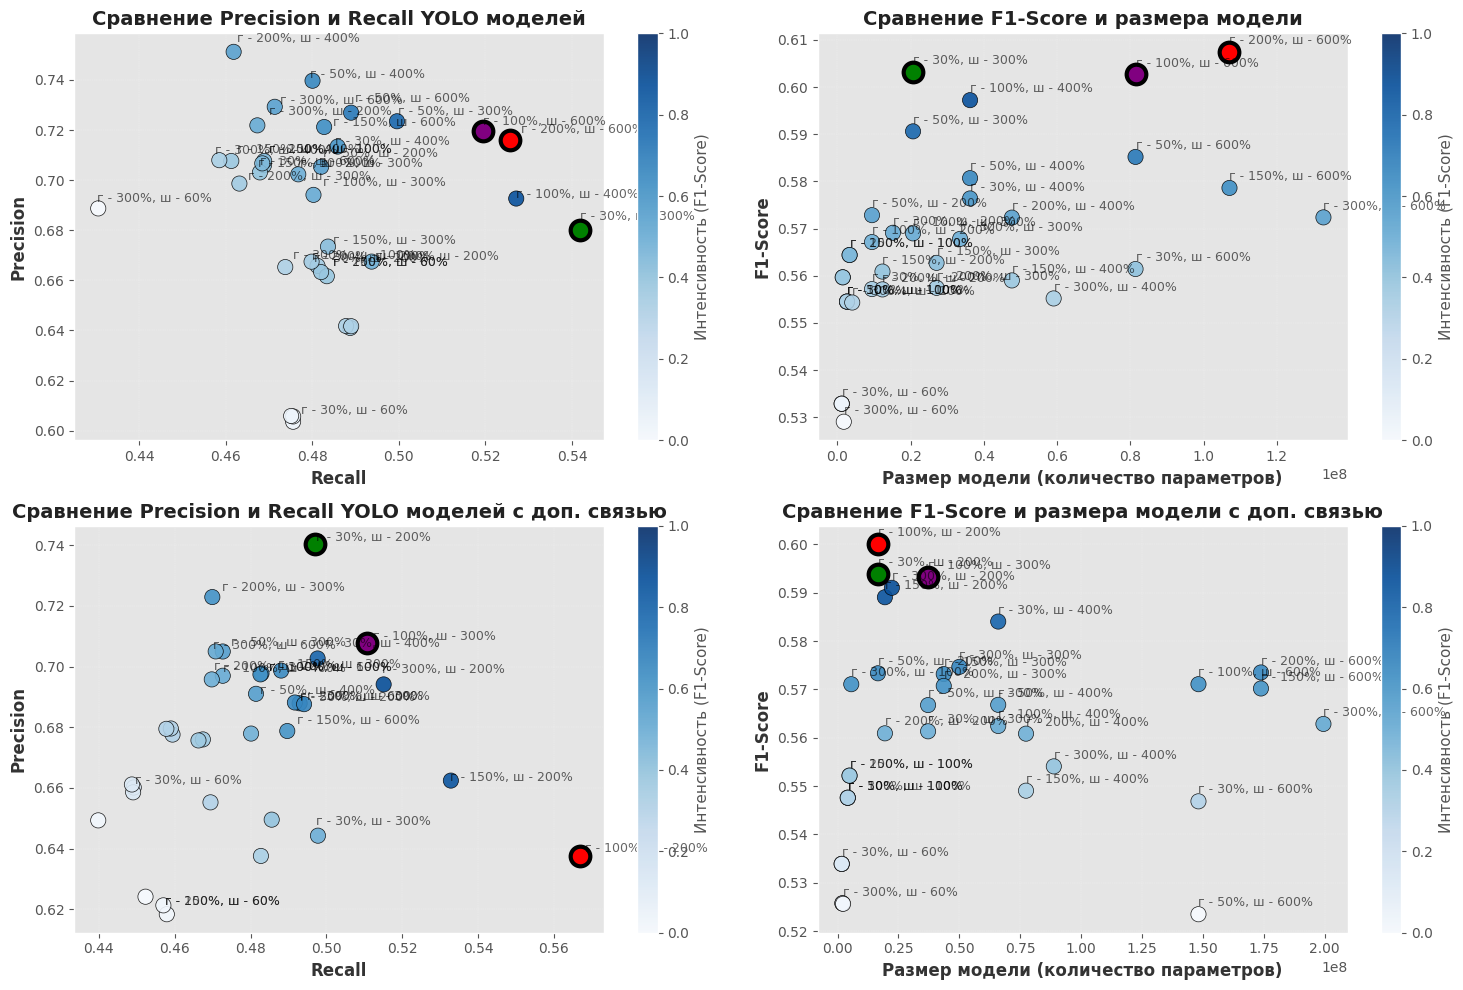

In [289]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from ultralytics import YOLO
import math

# –ë–∞–∑–æ–≤—ã–π —Ä–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏ YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """–ò–∑–≤–ª–µ–∫–∞–µ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä—ã depth –∏ width –∏–∑ –Ω–∞–∑–≤–∞–Ω–∏—è –ø–∞–ø–∫–∏ –≤ —Ñ–æ—Ä–º–∞—Ç–µ [depth_xx-width_xx] –∏ –ø–µ—Ä–µ–≤–æ–¥–∏—Ç –≤ —Ñ–æ—Ä–º–∞—Ç '–≥ - n%, —à - k%'"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # –ü–µ—Ä–µ–≤–æ–¥–∏–º –≤ –ø—Ä–æ—Ü–µ–Ω—Ç—ã –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –±–∞–∑–æ–≤–æ–≥–æ —Ä–∞–∑–º–µ—Ä–∞
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100
        if folder_name.startswith('extra'):
            return f"extra –≥ - {int(depth_percent)}%, —à - {int(width_percent)}%" 
        return f"–≥ - {int(depth_percent)}%, —à - {int(width_percent)}%"
    return None

def get_max_metrics(csv_path):
    """–ò–∑–≤–ª–µ–∫–∞–µ—Ç –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–µ Precision –∏ Recall –∏–∑ results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_precision = df["metrics/precision(B)"].max()
        max_recall = df["metrics/recall(B)"].max()
        return max_precision, max_recall
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ –æ–±—Ä–∞–±–æ—Ç–∫–µ {csv_path}: {e}")
        return None, None

def get_model_parameters(model_path):
    """–í–æ–∑–≤—Ä–∞—â–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –º–æ–¥–µ–ª–∏ YOLO"""
    model = YOLO(model_path)
    params = sum(p.numel() for p in model.parameters())  # –°—É–º–º–∏—Ä—É–µ–º –≤—Å–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –º–æ–¥–µ–ª–∏
    return params

def euclidean_distance_2d(point1, point2):
    """–í—ã—á–∏—Å–ª—è–µ—Ç –µ–≤–∫–ª–∏–¥–æ–≤–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –º–µ–∂–¥—É –¥–≤—É–º—è —Ç–æ—á–∫–∞–º–∏ –≤ 2D –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ"""
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def evaluate_models(logs_dir):
    """–°–æ–±–∏—Ä–∞–µ—Ç Precision, Recall –∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –∏ —Å—Ç—Ä–æ–∏—Ç –¥–≤–∞ –≥—Ä–∞—Ñ–∏–∫–∞"""
    results = {'extra': {}, 'base': {}}
    # –°—Ç–∏–ª—å –≥—Ä–∞—Ñ–∏–∫–∞
    plt.style.use("ggplot")  # –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ —Å—Ç–∏–ª—è ggplot
    for folder in sorted(os.listdir(logs_dir)):
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        model_name = extract_model_size(folder)
        if not model_name:
            continue

        csv_path = os.path.join(folder_path, "results.csv")
        if os.path.exists(csv_path):
            max_precision, max_recall = get_max_metrics(csv_path)
            if max_precision is not None and max_recall is not None:
                # –í—ã—á–∏—Å–ª–µ–Ω–∏–µ F1-—Å–∫–æ—Ä–∞
                f1_score = 2 * (max_precision * max_recall) / (max_precision + max_recall) if max_precision + max_recall != 0 else 0
                weights_path = os.path.join(folder_path, "weights", "best.pt")
                num_params = get_model_parameters(weights_path)  # –ü–æ–ª—É—á–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
                if 'extra' in folder_path:
                    results['extra'][model_name.replace('extra ', '')] = (max_precision, max_recall, num_params, f1_score)  # –î–æ–±–∞–≤–ª—è–µ–º F1-—Å–∫–æ—Ä
                else:
                    results['base'][model_name] = (max_precision, max_recall, num_params, f1_score)  # –î–æ–±–∞–≤–ª—è–µ–º F1-—Å–∫–æ—Ä
    
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    for i, mode in enumerate(['base', 'extra']):
        # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞ —Ü–≤–µ—Ç–∞
        recalls = np.array([r[1] for r in results[mode].values()])
        precisions = np.array([r[0] for r in results[mode].values()])
        model_sizes = np.array([r[2] for r in results[mode].values()])
        f1_scores = np.array([r[3] for r in results[mode].values()])  # –ú–∞—Å—Å–∏–≤ –¥–ª—è F1-—Å–∫–æ—Ä–∞

        # –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è —Ü–≤–µ—Ç–∞ –¥–ª—è F1-—Å–∫–æ—Ä–∞
        norm_colors = (f1_scores - f1_scores.min()) / (f1_scores.max() - f1_scores.min())  # –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è —Ü–≤–µ—Ç–∞ 
        # –î–æ–±–∞–≤–ª—è–µ–º jitter (—Ä–∞–∑–±—Ä–æ—Å) –¥–ª—è –∏–∑–±–µ–∂–∞–Ω–∏—è –Ω–∞–ª–æ–∂–µ–Ω–∏—è —Ç–æ—á–µ–∫
        jitter_strength = 0.002
        recalls += np.random.uniform(-jitter_strength, jitter_strength, size=len(recalls))
        precisions += np.random.uniform(-jitter_strength, jitter_strength, size=len(precisions))

        # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∏–Ω–¥–µ–∫—Å—ã –º–æ–¥–µ–ª–µ–π —Å –Ω–∞–∏–±–æ–ª—å—à–∏–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏ precision + recall
        sorted_indices = np.argsort(f1_scores)[::-1]  # –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ —É–±—ã–≤–∞–Ω–∏—é
        max_sum_index = sorted_indices[0]  # 1-–µ –º–µ—Å—Ç–æ (–∫—Ä–∞—Å–Ω–∞—è —Ç–æ—á–∫–∞)
        second_sum_index = sorted_indices[1] if len(sorted_indices) > 1 else None  # 2-–µ –º–µ—Å—Ç–æ (–∑–µ–ª–µ–Ω–∞—è —Ç–æ—á–∫–∞)
        third_sum_index = sorted_indices[2] if len(sorted_indices) > 2 else None  # 3-–µ –º–µ—Å—Ç–æ (—Ñ–∏–æ–ª–µ—Ç–æ–≤–∞—è —Ç–æ—á–∫–∞)
 
        # –ì—Ä–∞—Ñ–∏–∫ Precision vs Recall
        scatter1 = ax[i][0].scatter(recalls, precisions, c=norm_colors, cmap="Blues", s=120, edgecolors="black", alpha=0.9)

        # –í—ã–¥–µ–ª—è–µ–º —Ç–æ–ø-3 –º–æ–¥–µ–ª–∏
        ax[i][0].scatter(recalls[max_sum_index], precisions[max_sum_index], c='red', s=200, edgecolors='black', linewidth=3, alpha=1)
        if second_sum_index is not None:
            ax[i][0].scatter(recalls[second_sum_index], precisions[second_sum_index], c='green', s=200, edgecolors='black', linewidth=3, alpha=1)
        if third_sum_index is not None:
            ax[i][0].scatter(recalls[third_sum_index], precisions[third_sum_index], c='purple', s=200, edgecolors='black', linewidth=3, alpha=1)

        ax[i][0].set_xlabel("Recall", fontsize=12, fontweight="bold", color="#333")
        ax[i][0].set_ylabel("Precision", fontsize=12, fontweight="bold", color="#333") 
        ax[i][0].grid(True, linestyle="--", linewidth=0.3, alpha=0.5)  # –õ–µ–≥–∫–∞—è —Å–µ—Ç–∫–∞
        cbar1 = plt.colorbar(scatter1, ax=ax[i, 0])
        cbar1.set_label("–ò–Ω—Ç–µ–Ω—Å–∏–≤–Ω–æ—Å—Ç—å (F1-Score)", fontsize=11)

        # –ì—Ä–∞—Ñ–∏–∫ Precision vs Model Size (–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤) —Å F1-Score –Ω–∞ –æ—Å–∏ Y
        scatter2 = ax[i][1].scatter(model_sizes, f1_scores, c=norm_colors, cmap="Blues", s=120, edgecolors="black", alpha=0.9)

        # –í—ã–¥–µ–ª—è–µ–º —Ç–æ–ø-3 –º–æ–¥–µ–ª–∏ –Ω–∞ –ø—Ä–∞–≤–æ–º –≥—Ä–∞—Ñ–∏–∫–µ
        ax[i][1].scatter(model_sizes[max_sum_index], f1_scores[max_sum_index], c='red', s=200, edgecolors='black', linewidth=3, alpha=1)
        if second_sum_index is not None:
            ax[i][1].scatter(model_sizes[second_sum_index], f1_scores[second_sum_index], c='green', s=200, edgecolors='black', linewidth=3, alpha=1)
        if third_sum_index is not None:
            ax[i][1].scatter(model_sizes[third_sum_index], f1_scores[third_sum_index], c='purple', s=200, edgecolors='black', linewidth=3, alpha=1)
    
        seen_coords_prec = []
        seen_coords_f1 = []
        # –î–æ–±–∞–≤–ª—è–µ–º –ø–æ–¥–ø–∏—Å–∏ —Å –ø—Ä–æ–∑—Ä–∞—á–Ω–æ—Å—Ç—å—é —Ç–µ–∫—Å—Ç–∞
        for model, (precision, recall, size, f1_score) in results[mode].items():
            prec_flag, f1_flag = False, False
            if not seen_coords_prec:
                ax[i][0].text(recall + 0.001, precision + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6)
                ax[i][1].text(size + 0.001, f1_score + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6) 
                seen_coords_prec.append([precision, recall])
                seen_coords_f1.append([size, f1_score])
                continue
            
            for precision_new, recall_new in seen_coords_prec:
                if euclidean_distance_2d([precision_new, recall_new], [precision, recall]) < 0.04:
                    prec_flag = True
            if not prec_flag:
                ax[i][0].text(recall + 0.001, precision + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6)
                seen_coords_prec.append([precision_new, recall_new])
            for size_new, f1_score_new in seen_coords_f1:
                if euclidean_distance_2d([size_new/1e7, f1_score_new], [size/1e7, f1_score]) < 0.05: 
                    f1_flag = True
            if not f1_flag:
                ax[i][1].text(size + 0.001, f1_score + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6) 
                seen_coords_f1.append([size_new, f1_score_new])
                     
        ax[i][1].set_xlabel("–†–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏ (–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤)", fontsize=12, fontweight="bold", color="#333")
        ax[i][1].set_ylabel("F1-Score", fontsize=12, fontweight="bold", color="#333") 
        ax[i][1].grid(True, linestyle="--", linewidth=0.3, alpha=0.5)  # –õ–µ–≥–∫–∞—è —Å–µ—Ç–∫–∞
        cbar2 = plt.colorbar(scatter2, ax=ax[i, 1])
        cbar2.set_label("–ò–Ω—Ç–µ–Ω—Å–∏–≤–Ω–æ—Å—Ç—å (F1-Score)", fontsize=11)
    
    ax[0][1].set_title("–°—Ä–∞–≤–Ω–µ–Ω–∏–µ F1-Score –∏ —Ä–∞–∑–º–µ—Ä–∞ –º–æ–¥–µ–ª–∏", fontsize=14, fontweight="bold", color="#222")
    ax[0][0].set_title("–°—Ä–∞–≤–Ω–µ–Ω–∏–µ Precision –∏ Recall YOLO –º–æ–¥–µ–ª–µ–π", fontsize=14, fontweight="bold", color="#222")
    ax[1][1].set_title("–°—Ä–∞–≤–Ω–µ–Ω–∏–µ F1-Score –∏ —Ä–∞–∑–º–µ—Ä–∞ –º–æ–¥–µ–ª–∏ —Å –¥–æ–ø. —Å–≤—è–∑—å—é", fontsize=14, fontweight="bold", color="#222")
    ax[1][0].set_title("–°—Ä–∞–≤–Ω–µ–Ω–∏–µ Precision –∏ Recall YOLO –º–æ–¥–µ–ª–µ–π —Å –¥–æ–ø. —Å–≤—è–∑—å—é", fontsize=14, fontweight="bold", color="#222")
    
    


    plt.tight_layout() 
    plt.show()

# –ü—É—Ç–∏
logs_dir = "../detection/logs/yolo11/"

# –ó–∞–ø—É—Å–∫
evaluate_models(logs_dir)


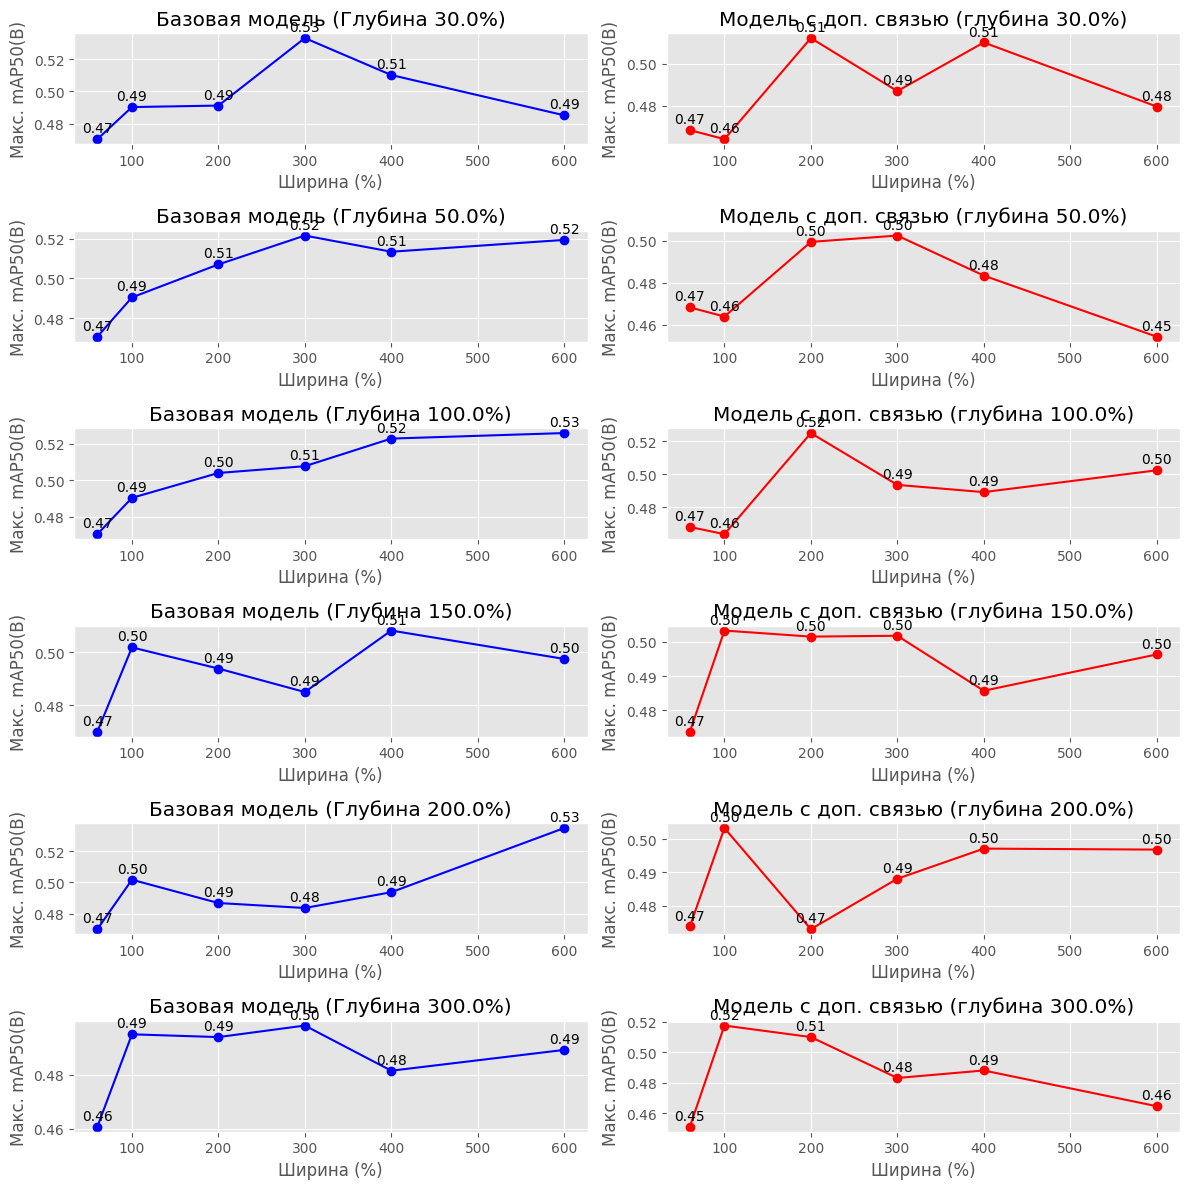

In [367]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def extract_model_size(folder_name):
    """–ò–∑–≤–ª–µ–∫–∞–µ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä—ã depth –∏ width –∏–∑ –Ω–∞–∑–≤–∞–Ω–∏—è –ø–∞–ø–∫–∏ –≤ —Ñ–æ—Ä–º–∞—Ç–µ [depth_xx-width_xx] –∏ –ø–µ—Ä–µ–≤–æ–¥–∏—Ç –≤ –ø—Ä–æ—Ü–µ–Ω—Ç—ã –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –±–∞–∑–æ–≤–æ–≥–æ —Ä–∞–∑–º–µ—Ä–∞"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1))/0.5 * 100
        width = float(match.group(2))/0.25 * 100
        return depth, width
    return None, None

def get_max_mAP(csv_path):
    """–ò–∑–≤–ª–µ–∫–∞–µ—Ç –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ metrics/mAP50(B) –∏–∑ results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_map = df["metrics/mAP50(B)"].max()
        return max_map
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ –æ–±—Ä–∞–±–æ—Ç–∫–µ {csv_path}: {e}")
        return None

def gather_data(logs_dir, extra=False):
    """–°–æ–±–∏—Ä–∞–µ—Ç –¥–∞–Ω–Ω—ã–µ –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è –≥—Ä–∞—Ñ–∏–∫–∞ –¥–ª—è –º–æ–¥–µ–ª–µ–π (—Å/–±–µ–∑ 'extra')"""
    model_data = defaultdict(list)
    # –°—Ç–∏–ª—å –≥—Ä–∞—Ñ–∏–∫–∞
    plt.style.use("ggplot")
    for folder in sorted(os.listdir(logs_dir)):
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        
        if extra and not folder.startswith("extra_"):
            continue
        if not extra and folder.startswith("extra_"):
            continue

        # –ò–∑–≤–ª–µ–∫–∞–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –º–æ–¥–µ–ª–∏
        depth, width = extract_model_size(folder)
        if depth is None or width is None:
            continue

        # –ü—É—Ç—å –¥–æ —Ñ–∞–π–ª–∞ results.csv
        csv_path = os.path.join(folder_path, "results.csv")
        max_map = get_max_mAP(csv_path)
        if max_map is not None:
            model_data[depth].append((width, max_map))

    return model_data

# –ü–æ–ª—É—á–∞–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –∏ –¥–ª—è –º–æ–¥–µ–ª–µ–π —Å 'extra_'
logs_dir = "/home/user/master_degree/pits_detection/detection/logs/yolo11"
base_data = gather_data(logs_dir, extra=False)
extra_data = gather_data(logs_dir, extra=True)

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –≥–ª—É–±–∏–Ω—ã (depth) –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è –≥—Ä–∞—Ñ–∏–∫–æ–≤
num_depths = len(base_data)

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–æ–≤
fig, ax = plt.subplots(num_depths, 2, figsize=(12, 12))

# –ì—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –±–∞–∑–æ–≤—ã—Ö –º–æ–¥–µ–ª–µ–π
for i, (depth, data) in enumerate(base_data.items()):
    widths = [d[0] for d in data]
    maps = [d[1] for d in data]

    ax[i, 0].plot(widths, maps, 'bo-', label=f'–ì–ª—É–±–∏–Ω–∞ {depth}%') 
    for x, y in zip(widths, maps):
        ax[i, 0].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center') 
    ax[i, 0].set_title(f'–ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å (–ì–ª—É–±–∏–Ω–∞ {depth}%)')
    ax[i, 0].set_xlabel('–®–∏—Ä–∏–Ω–∞ (%)')
    ax[i, 0].set_ylabel('–ú–∞–∫—Å. mAP50(B)')
    ax[i, 0].grid(True)

# –ì—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –º–æ–¥–µ–ª–µ–π —Å "extra_"
for i, (depth, data) in enumerate(extra_data.items()):
    widths = [d[0] for d in data]
    maps = [d[1] for d in data]

    ax[i, 1].plot(widths, maps, 'ro-', label=f'Depth {depth}%')
    for x, y in zip(widths, maps):
        ax[i, 1].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center') 
    ax[i, 1].set_title(f'–ú–æ–¥–µ–ª—å —Å –¥–æ–ø. —Å–≤—è–∑—å—é (–≥–ª—É–±–∏–Ω–∞ {depth}%)')
    ax[i, 1].set_xlabel('–®–∏—Ä–∏–Ω–∞ (%)')
    ax[i, 1].set_ylabel('–ú–∞–∫—Å. mAP50(B)')
    ax[i, 1].grid(True)

# –û—Ç–æ–±—Ä–∞–∂–∞–µ–º –≥—Ä–∞—Ñ–∏–∫

plt.tight_layout()
plt.show()




In [354]:
aggregated_base_depth

{15.0: 0.4967916666666666,
 25.0: 0.5037233333333333,
 50.0: 0.503515,
 75.0: 0.49272000000000005,
 100.0: 0.49517000000000005,
 150.0: 0.48632499999999995}

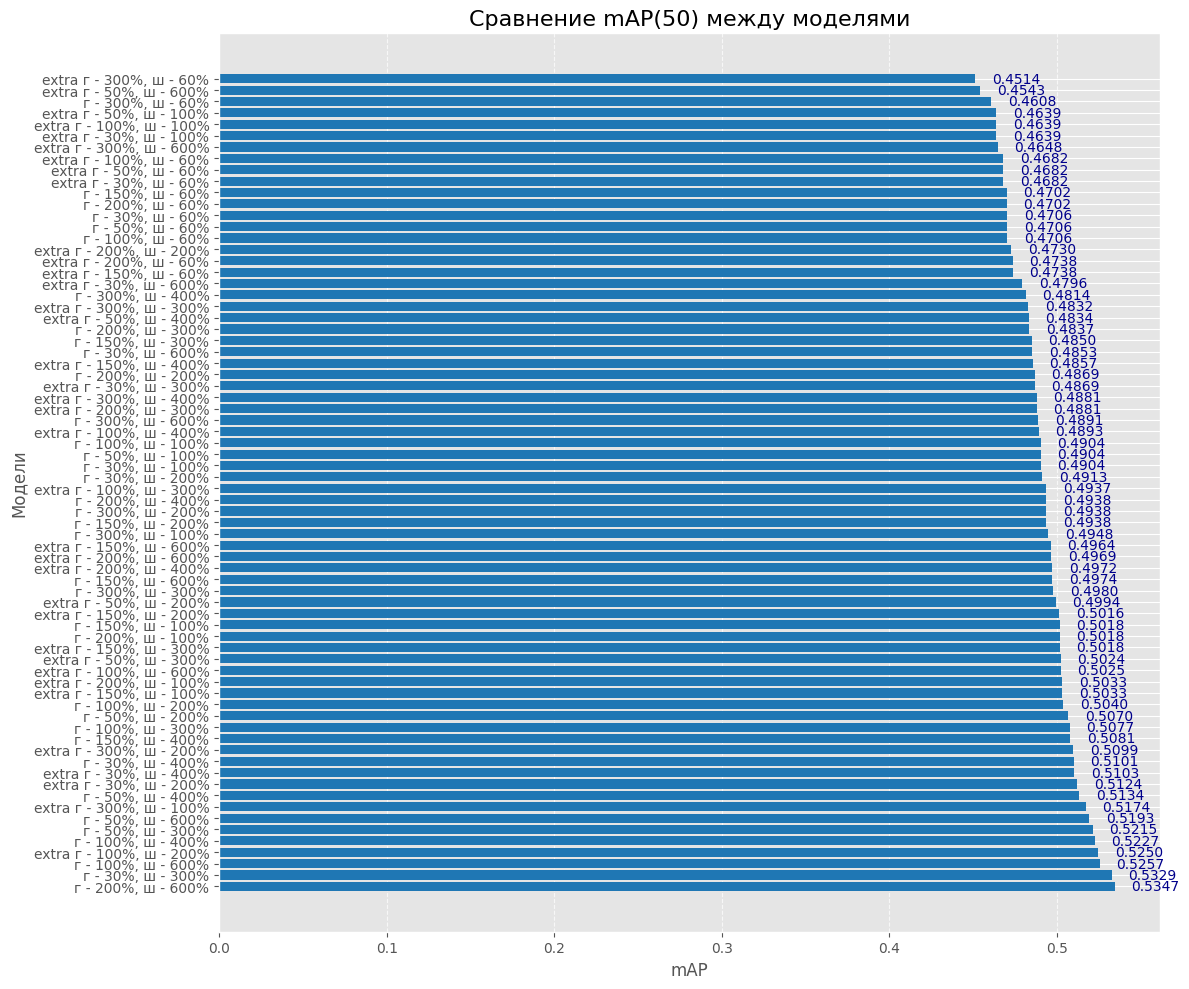

In [293]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import re  # –î–ª—è —Ä–∞–±–æ—Ç—ã —Å —Ä–µ–≥—É–ª—è—Ä–Ω—ã–º–∏ –≤—ã—Ä–∞–∂–µ–Ω–∏—è–º–∏

# –ü—É—Ç—å –∫ –ø–∞–ø–∫–µ —Å –ª–æ–≥–∞–º–∏
logs_path = '/home/user/master_degree/pits_detection/detection/logs/yolo11'
# –ë–∞–∑–æ–≤—ã–π —Ä–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏ YOLO
base_yolo_size = [0.50, 0.25]
# –°–ø–∏—Å–æ–∫ –º–æ–¥–µ–ª–µ–π
model_folders = [f for f in os.listdir(logs_path) if os.path.isdir(os.path.join(logs_path, f))]

# –°–ø–∏—Å–æ–∫ mAP –¥–ª—è –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏
model_names = []
map_values = []

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –Ω–∞–∑–≤–∞–Ω–∏–π –ø–∞–ø–æ–∫
def format_folder_name(folder_name):
    match = re.search(r'depth_(\d+\.\d+)-width_(\d+\.\d+)', folder_name)
    if match: 
        # –ü–µ—Ä–µ–≤–æ–¥–∏–º –≤ –ø—Ä–æ—Ü–µ–Ω—Ç—ã –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –±–∞–∑–æ–≤–æ–≥–æ —Ä–∞–∑–º–µ—Ä–∞
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100
        if folder_name.startswith('extra'):
            return f"extra –≥ - {int(depth_percent)}%, —à - {int(width_percent)}%" 
        return f"–≥ - {int(depth_percent)}%, —à - {int(width_percent)}%"
    return folder_name

for folder in model_folders:
    result_csv = os.path.join(logs_path, folder, 'results.csv')
    if os.path.exists(result_csv):
        df = pd.read_csv(result_csv)
        # –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º, —á—Ç–æ —Å—Ç–æ–ª–±–µ—Ü 'mAP' –≤ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞—Ö csv
        mAP = df['metrics/mAP50(B)'].max()  # –ë–µ—Ä–µ–º –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π mAP
        model_names.append(folder)
        map_values.append(mAP)

 
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Å–µ –Ω–∞–∑–≤–∞–Ω–∏—è –ø–∞–ø–æ–∫ –Ω–∞ –æ—Å–∏ Y
formatted_model_names = [format_folder_name(name) for name in model_names]

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –∑–Ω–∞—á–µ–Ω–∏—è–º mAP (–ø–æ —É–±—ã–≤–∞–Ω–∏—é)
sorted_data = sorted(zip(formatted_model_names, map_values), key=lambda x: x[1], reverse=True)

# –†–∞–∑–¥–µ–ª—è–µ–º –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –æ–±—Ä–∞—Ç–Ω–æ –Ω–∞ –æ—Ç–¥–µ–ª—å–Ω—ã–µ —Å–ø–∏—Å–∫–∏
sorted_model_names, sorted_map_values = zip(*sorted_data)

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(12, 10))
plt.barh(sorted_model_names, sorted_map_values, color='#1f77b4')  # –ò—Å–ø–æ–ª—å–∑—É–µ–º —Å–∏–Ω–∏–π –æ—Ç—Ç–µ–Ω–æ–∫

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –≥—Ä–∞—Ñ–∏–∫–∞
plt.xlabel('mAP', fontsize=12)
plt.ylabel('–ú–æ–¥–µ–ª–∏', fontsize=12)
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ mAP(50) –º–µ–∂–¥—É –º–æ–¥–µ–ª—è–º–∏', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# –î–æ–±–∞–≤–ª—è–µ–º –∑–Ω–∞—á–µ–Ω–∏—è mAP –Ω–∞ –≥—Ä–∞—Ñ–∏–∫
for i, (value, name) in enumerate(zip(sorted_map_values, sorted_model_names)):
    plt.text(value + 0.01, i, f'{value:.4f}', va='center', fontsize=10, color='darkblue')

# –ü–æ–∫–∞–∑–∞—Ç—å –≥—Ä–∞—Ñ–∏–∫
plt.tight_layout()
plt.show()


In [370]:
import cv2
import segmentation_models_pytorch as smp
import torch
import numpy as np
import os
from pathlib import Path
from sklearn.metrics import precision_score, recall_score

# –ü–∞—Ä–∞–º–µ—Ç—Ä –ø–æ—Ä–æ–≥–∞ –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏—è
iou_threshold = 0.5  
precision_before_all, recall_before_all = [], []
precision_after_all, recall_after_all = [], []
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è IoU –º–µ–∂–¥—É –º–∞—Å–∫–æ–π –¥–æ—Ä–æ–≥–∏ –∏ –¥–µ—Ç–µ–∫—Ü–∏–µ–π
def compute_iou_segment(mask, box):
    x1, y1, x2, y2 = map(int, box) 
    roi = mask[y1:y2, x1:x2]
    intersection = np.sum(roi)  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∏–∫—Å–µ–ª–µ–π, –ø–æ–ø–∞–≤—à–∏—Ö –≤ —Å–µ–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—É—é –¥–æ—Ä–æ–≥—É
    box_area = (x2 - x1) * (y2 - y1)
    iou = intersection / box_area if box_area > 0 else 0
    return iou

def clean_segmentation_mask(pred_mask, min_region_size=250):
    """
    –û—á–∏—â–∞–µ—Ç —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–æ–Ω–Ω—É—é –º–∞—Å–∫—É –æ—Ç —Å–ª—É—á–∞–π–Ω—ã—Ö –ø–∏–∫—Å–µ–ª–µ–π, –æ—Å—Ç–∞–≤–ª—è—è —Ç–æ–ª—å–∫–æ –≥–ª–∞–≤–Ω—ã–π —Ä–µ–≥–∏–æ–Ω.
    
    :param pred_mask: –í—Ö–æ–¥–Ω–∞—è –±–∏–Ω–∞—Ä–Ω–∞—è –º–∞—Å–∫–∞ (numpy array, 0 –∏ 1).
    :param min_region_size: –ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–π —Ä–∞–∑–º–µ—Ä –æ–±–ª–∞—Å—Ç–∏, –∫–æ—Ç–æ—Ä—É—é —Å—á–∏—Ç–∞–µ–º –∑–Ω–∞—á–∏–º–æ–π.
    :return: –û—á–∏—â–µ–Ω–Ω–∞—è –±–∏–Ω–∞—Ä–Ω–∞—è –º–∞—Å–∫–∞ (0 –∏ 1).
    """
    # –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ —Ç–∏–ø –¥–∞–Ω–Ω—ã—Ö uint8 (—Ç—Ä–µ–±—É–µ—Ç—Å—è –¥–ª—è OpenCV)
    pred_mask = (pred_mask * 255).astype(np.uint8)

    # –ú–æ—Ä—Ñ–æ–ª–æ–≥–∏—á–µ—Å–∫–æ–µ –∑–∞–∫—Ä—ã—Ç–∏–µ (—É–±–∏—Ä–∞–µ–º —Ä–∞–∑—Ä—ã–≤—ã –∏ –æ–¥–∏–Ω–æ—á–Ω—ã–µ –ø–∏–∫—Å–µ–ª–∏)
    kernel = np.ones((2, 2), np.uint8)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # –£–±–∏—Ä–∞–µ–º –º–µ–ª–∫–∏–µ —à—É–º–Ω—ã–µ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã (–ø–æ–∏—Å–∫ —Å–≤—è–∑–Ω—ã—Ö –æ–±–ª–∞—Å—Ç–µ–π)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(pred_mask, connectivity=8)

    # –ï—Å–ª–∏ –Ω–∞–π–¥–µ–Ω–æ –Ω–µ—Å–∫–æ–ª—å–∫–æ –æ–±–ª–∞—Å—Ç–µ–π, –æ—Å—Ç–∞–≤–ª—è–µ–º —Ç–æ–ª—å–∫–æ —Å–∞–º—É—é –±–æ–ª—å—à—É—é
    new_mask = np.zeros_like(pred_mask)
    
    # –ü–µ—Ä–µ–±–∏—Ä–∞–µ–º –≤—Å–µ –Ω–∞–π–¥–µ–Ω–Ω—ã–µ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã
    for i in range(1, num_labels):  # –ü–µ—Ä–≤—ã–π –∏–Ω–¥–µ–∫—Å (0) ‚Äî —Ñ–æ–Ω
        area = stats[i, cv2.CC_STAT_AREA]
        if area > min_region_size:  # –£—Å–ª–æ–≤–∏–µ: –æ—Å—Ç–∞–≤–∏—Ç—å —Ç–æ–ª—å–∫–æ –±–æ–ª—å—à–∏–µ —Ä–µ–≥–∏–æ–Ω—ã
            new_mask[labels == i] = 255  # –ó–∞–ø–æ–ª–Ω—è–µ–º –Ω–∞–π–¥–µ–Ω–Ω—É—é –æ–±–ª–∞—Å—Ç—å –±–µ–ª—ã–º

    return (new_mask > 0).astype(np.uint8)  # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –æ–±—Ä–∞—Ç–Ω–æ –≤ 0 –∏ 1

def compute_iou(box1, box2):
    """ –§—É–Ω–∫—Ü–∏—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è IoU (Intersection over Union) –º–µ–∂–¥—É –¥–≤—É–º—è –±–æ–∫—Å–∞–º–∏ """
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏—è
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    # –í—ã—á–∏—Å–ª—è–µ–º –ø–ª–æ—â–∞–¥—å –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏—è
    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    intersection = inter_width * inter_height

    # –ü–ª–æ—â–∞–¥–∏ –±–æ–∫—Å–æ–≤
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x2g - x1g) * (y2g - y1g)

    # –í—ã—á–∏—Å–ª—è–µ–º IoU
    iou = intersection / float(area1 + area2 - intersection)
    return iou


def get_seg_model(encoder_name, checkpoint_path = f'../segmantation/logs/Linknet/resnet101/version_4/checkpoints/epoch=79-step=1360.ckpt'): 
    seg_model = smp.create_model(
                'Linknet',
                encoder_name=encoder_name,
                in_channels=3,
                classes=1 )  
    new_weights = rename_state_dict(checkpoint_path, seg_model)
    seg_model.load_state_dict(new_weights) 
    seg_model.eval()
    return seg_model

def get_det_model(checkpoint_path = f'detection/logs/yolo11/[depth_1.0-width_1.5]/weights/best.pt'):
    return YOLO(checkpoint_path) 

def get_mask(image_numpy, seg_model):
    #checkpoint_path = f'logs/{model_name}/resnet34/version_0/checkpoints/epoch=199-step=9200.ckpt' 
    tensor_img = torch.tensor(image_numpy / 255, dtype=torch.float32)
    mean = torch.tensor([[[[0.4850]], [[0.4560]], [[0.4060]]]])
    std = torch.tensor([[[[0.2290]], [[0.2240]], [[0.2250]]]])
    with torch.no_grad():
        tensor_img = (tensor_img - mean) / std
        logits_mask = seg_model(tensor_img)
    prob_mask = logits_mask.sigmoid()
    pred_mask = (prob_mask > 0.1).float()
    
    return clean_segmentation_mask(pred_mask.squeeze().detach().numpy())

# –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è –±–æ–∫—Å–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –ø–µ—Ä–µ—Å–µ–∫–∞—é—Ç—Å—è —Å –¥–æ—Ä–æ–≥–æ–π
def filter_boxes(yolo_boxes, yolo_confs, mask, threshold=0.3):
    filtered_boxes = []
    filtered_confs = []
    for box, conf in zip(yolo_boxes, yolo_confs):
        iou = compute_iou_segment(mask, box)
        if iou >= threshold:
            filtered_boxes.append(box)
            filtered_confs.append(conf)
    return np.array(filtered_boxes), np.array(filtered_confs)

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∑–∞–≥—Ä—É–∑–∫–∏ –∏—Å—Ç–∏–Ω–Ω—ã—Ö –±–æ–∫—Å–æ–≤ –∏–∑ YOLO-—Ñ–æ—Ä–º–∞—Ç–∞
def load_true_boxes(label_path, img_width, img_height):
    true_boxes = []
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            _, x, y, w, h = map(float, line.strip().split())
            x1 = int((x - w / 2) * img_width)
            y1 = int((y - h / 2) * img_height)
            x2 = int((x + w / 2) * img_width)
            y2 = int((y + h / 2) * img_height)
            true_boxes.append([x1, y1, x2, y2])
    return np.array(true_boxes)

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è Precision –∏ Recall
def calculate_metrics(pred_boxes, true_boxes, iou_threshold=0.5):
    true_labels = np.ones(max(len(true_boxes), len(pred_boxes)), dtype=int)
    pred_labels = np.zeros(max(len(true_boxes), len(pred_boxes)), dtype=int)
    for i, true_box in enumerate(true_boxes):
        for j, pred_box in enumerate(pred_boxes): 
            if compute_iou(true_box, pred_box) >= iou_threshold: 
                pred_labels[i] = 1 

    precision = precision_score(true_labels, pred_labels, zero_division=1)
    recall = recall_score(true_labels, pred_labels, zero_division=1)
    return precision, recall


def save_image_with_boxes(image, mask, yolo_boxes_before, yolo_boxes_after, output_path, img_w, img_h):
    """
    –°–æ—Ö—Ä–∞–Ω—è–µ—Ç –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ, —Å–æ—Å—Ç–æ—è—â–µ–µ –∏–∑ 3 —á–∞—Å—Ç–µ–π: –º–∞—Å–∫–∞, –¥–µ—Ç–µ–∫—Ü–∏—è –¥–æ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏, –¥–µ—Ç–µ–∫—Ü–∏—è –ø–æ—Å–ª–µ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏.
    
    :param image: –û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
    :param mask: –ú–∞—Å–∫–∞ —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–∏
    :param yolo_boxes_before: –î–µ—Ç–µ–∫—Ü–∏–∏ –¥–æ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏
    :param yolo_boxes_after: –î–µ—Ç–µ–∫—Ü–∏–∏ –ø–æ—Å–ª–µ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏
    :param output_path: –ü—É—Ç—å –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
    """
     
    # –†–∏—Å—É–µ–º –±–æ–∫—Å—ã –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏ –¥–æ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏
    image_before = image.copy()
    image_before = cv2.resize(image_before, (img_w, img_h))
    for box in yolo_boxes_before:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_before, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # –†–∏—Å—É–µ–º –±–æ–∫—Å—ã –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏ –ø–æ—Å–ª–µ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏
    image_after = image.copy()
    image_after = cv2.resize(image_after, (img_w, img_h))
    for box in yolo_boxes_after:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_after, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # –†–∏—Å—É–µ–º –º–∞—Å–∫—É  
    mask_resized = cv2.resize(mask, (img_w, img_h))
    mask_colored_resized = np.stack([mask_resized*255] * 3, axis=-1)  # –ú–∞—Å–∫–∞ –∫–∞–∫ —Ü–≤–µ—Ç–Ω–∞—è –∫–∞—Ä—Ç–∏–Ω–∫–∞ 
    # –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
    combined_image = np.concatenate([mask_colored_resized, image_before, image_after], axis=1)

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
    cv2.imwrite(output_path, combined_image)


# –û—Å–Ω–æ–≤–Ω–æ–π –ø—Ä–æ—Ü–µ—Å—Å
def process_images_and_save_results(images_path, labels_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_name in os.listdir(images_path):
        if not image_name.endswith(".jpg"):
            continue
        img_h = 512
        img_w = 512 
        image_path = os.path.join(images_path, image_name)
        label_path = os.path.join(labels_path, Path(image_name).stem + ".txt")

       # –ß–∏—Ç–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
        frame = cv2.imread(image_path, 1)
        img_original = frame# cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_original_resized = cv2.resize(img_original, (img_w,img_h))  
        img_original_transp = np.transpose(img_original_resized, (2, 0, 1)) 

        # –ü–æ–ª—É—á–∞–µ–º –º–∞—Å–∫—É —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–∏
        mask = get_mask(image_numpy=img_original_transp, seg_model=seg_model) 

        # YOLO –¥–µ—Ç–µ–∫—Ü–∏—è
        detect_result = det_model(frame, conf=0.3, iou=0.3, verbose = False)
        yolo_boxes = detect_result[0].boxes.xyxy.cpu().numpy()
        yolo_confs = detect_result[0].boxes.conf.cpu().numpy()
        orig_h, orig_w, _ = frame.shape
        
        # –ú–∞—Å—à—Ç–∞–±–∏—Ä—É–µ–º YOLO –±–æ–∫—Å—ã –≤ —Ä–∞–∑–º–µ—Ä mask (512x512)
        scale_x = img_w / orig_w
        scale_y = img_h / orig_h
        scaled_boxes = yolo_boxes.copy() 
        scaled_boxes[:, [0, 2]] *= scale_x  # x1, x2
        scaled_boxes[:, [1, 3]] *= scale_y  # y1, y2
        scaled_boxes = scaled_boxes.astype(int)  # –û–∫—Ä—É–≥–ª—è–µ–º –¥–æ —Ü–µ–ª—ã—Ö –ø–∏–∫—Å–µ–ª–µ–π
        
        # –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è –±–æ–∫—Å–æ–≤ –ø–æ –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏—é —Å –¥–æ—Ä–æ–≥–æ–π
        filtered_boxes, filtered_confs = filter_boxes(scaled_boxes, yolo_confs, mask, iou_threshold)
        
        # –ó–∞–≥—Ä—É–∂–∞–µ–º –∏—Å—Ç–∏–Ω–Ω—ã–µ –±–æ–∫—Å—ã
        if not os.path.exists(label_path):
            continue  # –ü—Ä–æ–ø—É—Å–∫–∞–µ–º, –µ—Å–ª–∏ –Ω–µ—Ç —Ä–∞–∑–º–µ—Ç–∫–∏
        true_boxes = load_true_boxes(label_path, img_w, img_h) 
        # –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫ –¥–æ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏
        precision_before, recall_before = calculate_metrics(scaled_boxes, true_boxes)
        if len(mask.shape) > 1:
            precision_after, recall_after = calculate_metrics(filtered_boxes, true_boxes) 
        else:
            precision_after, recall_after = precision_before, recall_before
        precision_before_all.append(precision_before)
        recall_before_all.append(recall_before)
        precision_after_all.append(precision_after)
        recall_after_all.append(recall_after)
        # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏
        output_image_path = os.path.join(output_folder, f"{Path(image_name).stem}_result.jpg")
        save_image_with_boxes(img_original, mask, scaled_boxes, filtered_boxes, output_image_path, img_w, img_h)

        #print(f"Results saved for {image_name}. Precision before: {precision_before:.3f}, Recall before: {recall_before:.3f}")
       # print(f"Precision after: {precision_after:.3f}, Recall after: {recall_after:.3f}")
    print(f'Average precision before: {np.mean(precision_before_all)}, Average recall before: {np.mean(recall_before_all)}  \
          Average precision after: {np.mean(precision_after_all)}, Average recall after: {np.mean(recall_after_all)}')
# –ó–∞–ø—É—Å–∫
images_path = "/home/user/master_degree/pits_detection/detection/data/yolo_format/images/train"
labels_path = "/home/user/master_degree/pits_detection/detection/data/yolo_format/labels/train"
output_folder = "train_pipeline_result"
 


In [371]:
process_images_and_save_results(images_path, labels_path, output_folder)

KeyboardInterrupt: 

[0.47064, 0.49041, 0.49132, 0.5329, 0.51014, 0.48534, 0.47064, 0.49041, 0.507, 0.52154, 0.5134, 0.51935, 0.47064, 0.49041, 0.50397, 0.50766, 0.5227, 0.52571, 0.4702, 0.50175, 0.49383, 0.48504, 0.50806, 0.49744, 0.4702, 0.50175, 0.48687, 0.48371, 0.49378, 0.53471, 0.46083, 0.49481, 0.49379, 0.49803, 0.48142, 0.48907]
[0.46823, 0.46389, 0.5124, 0.48694, 0.51028, 0.47956, 0.46823, 0.46389, 0.49941, 0.50243, 0.48338, 0.4543, 0.46823, 0.46389, 0.52497, 0.49367, 0.48929, 0.50247, 0.47377, 0.50334, 0.50157, 0.50182, 0.48574, 0.49635, 0.47377, 0.50334, 0.47296, 0.48811, 0.49716, 0.49687, 0.45141, 0.51737, 0.50987, 0.48317, 0.48807, 0.46477]


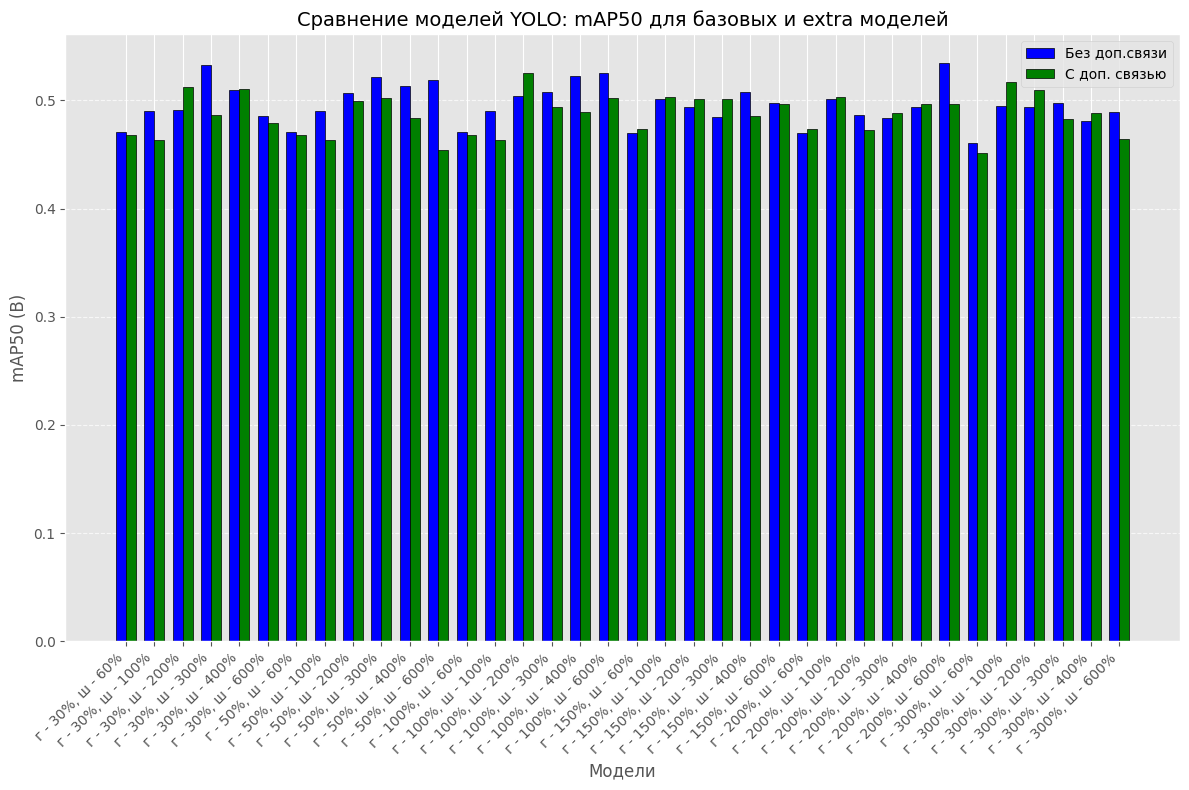

In [368]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∏–∑–≤–ª–µ—á–µ–Ω–∏—è –≥–ª—É–±–∏–Ω—ã –∏ —à–∏—Ä–∏–Ω—ã –∏–∑ –Ω–∞–∑–≤–∞–Ω–∏—è –ø–∞–ø–∫–∏
def extract_model_size(folder_name):
    """–ò–∑–≤–ª–µ–∫–∞–µ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä—ã depth –∏ width –∏–∑ –Ω–∞–∑–≤–∞–Ω–∏—è –ø–∞–ø–∫–∏ –≤ —Ñ–æ—Ä–º–∞—Ç–µ [depth_xx-width_xx]"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = (float(match.group(1))/0.5) * 100
        width = (float(match.group(2))/0.25) * 100
        return depth, width
    return None, None

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è mAP50 –∏–∑ results.csv
def get_max_map(csv_path):
    """–ò–∑–≤–ª–µ–∫–∞–µ—Ç –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ mAP50 –∏–∑ results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_map = df["metrics/mAP50(B)"].max()
        return max_map
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ –æ–±—Ä–∞–±–æ—Ç–∫–µ {csv_path}: {e}")
        return None

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è –ø–∞—Ä–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤
def plot_comparison_bar_chart(logs_dir):
    """–°—Ç—Ä–æ–∏—Ç –≥—Ä–∞—Ñ–∏–∫ —Å –ø–∞—Ä–Ω—ã–º–∏ —Å—Ç–æ–ª–±—Ü–∞–º–∏ –¥–ª—è –º–æ–¥–µ–ª–µ–π YOLO"""
    model_names = []  # –°–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –Ω–∞–∑–≤–∞–Ω–∏–π –º–æ–¥–µ–ª–µ–π
    mAP_values_base = []  # –°–ø–∏—Å–æ–∫ –¥–ª—è –∑–Ω–∞—á–µ–Ω–∏–π mAP50 –¥–ª—è –±–∞–∑–æ–≤—ã—Ö –º–æ–¥–µ–ª–µ–π
    mAP_values_extra = []  # –°–ø–∏—Å–æ–∫ –¥–ª—è –∑–Ω–∞—á–µ–Ω–∏–π mAP50 –¥–ª—è –º–æ–¥–µ–ª–µ–π —Å 'extra_'

    # –ü—Ä–æ—Ö–æ–¥–∏–º –ø–æ –≤—Å–µ–º –ø–∞–ø–∫–∞–º —Å –ª–æ–≥–∞–º–∏
    for folder in sorted(os.listdir(logs_dir)):
        if 'extra' in folder:
            continue
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue 
        # –ò–∑–≤–ª–µ–∫–∞–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –º–æ–¥–µ–ª–∏ –∏–∑ –Ω–∞–∑–≤–∞–Ω–∏—è –ø–∞–ø–∫–∏
        depth, width = extract_model_size(folder)
        if depth is None or width is None:
            continue
        
        # –ü–æ–ª—É—á–∞–µ–º –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ mAP50 –∏–∑ —Ñ–∞–π–ª–∞ results.csv –¥–ª—è –±–∞–∑–æ–≤–æ–π –º–æ–¥–µ–ª–∏
        csv_path_base = os.path.join(folder_path, "results.csv")
        max_map_base = get_max_map(csv_path_base)

        if max_map_base is not None:
            model_name = f"–≥ - {int(depth)}%, —à - {int(width)}%"
            model_names.append(model_name)
            mAP_values_base.append(max_map_base)

            # –î–ª—è –º–æ–¥–µ–ª–∏ —Å –ø—Ä–µ—Ñ–∏–∫—Å–æ–º "extra_" –∏—â–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
            extra_folder = f"extra_{folder}"
            extra_folder_path = os.path.join(logs_dir, extra_folder)

            if os.path.isdir(extra_folder_path):
                csv_path_extra = os.path.join(extra_folder_path, "results.csv")
                max_map_extra = get_max_map(csv_path_extra)
                mAP_values_extra.append(max_map_extra)
    # –°—Ç–∏–ª—å –≥—Ä–∞—Ñ–∏–∫–∞
    plt.style.use("ggplot")
    # –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
    fig, ax = plt.subplots(figsize=(12, 8))

    # –ò–Ω–¥–µ–∫—Å—ã –¥–ª—è –ø–∞—Ä–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤
    x = np.arange(len(model_names))  # –ü–æ–∑–∏—Ü–∏–∏ –º–æ–¥–µ–ª–µ–π –ø–æ –æ—Å–∏ X
    width = 0.35  # –®–∏—Ä–∏–Ω–∞ —Å—Ç–æ–ª–±—Ü–∞

    # –°–æ—Ä—Ç–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –∑–Ω–∞—á–µ–Ω–∏—è–º mAP (–ø–æ —É–±—ã–≤–∞–Ω–∏—é)
    #sorted_data = sorted(zip(model_names, mAP_values_base), key=lambda x: x[1], reverse=True)
    #sorted_data_extra = sorted(zip(model_names, mAP_values_extra), key=lambda x: x[1], reverse=True)

    # –†–∞–∑–¥–µ–ª—è–µ–º –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –æ–±—Ä–∞—Ç–Ω–æ –Ω–∞ –æ—Ç–¥–µ–ª—å–Ω—ã–µ —Å–ø–∏—Å–∫–∏
    #sorted_model_names_extra, sorted_map_values = zip(*sorted_data)
    #sorted_model_names_extra, sorted_map_values_extra = zip(*sorted_data_extra)
    
    print(mAP_values_base)
    print(mAP_values_extra)
    # –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –ø–∞—Ä–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤
    ax.bar(x - width/2, mAP_values_base, width, label='–ë–µ–∑ –¥–æ–ø.—Å–≤—è–∑–∏', color='b', edgecolor='black')
    ax.bar(x + width/2, mAP_values_extra, width, label='–° –¥–æ–ø. —Å–≤—è–∑—å—é', color='green', edgecolor='black')

    # –ù–∞—Å—Ç—Ä–æ–∏–º –ø–æ–¥–ø–∏—Å–∏ –∏ —Ç–∏—Ç—É–ª
    ax.set_xlabel('–ú–æ–¥–µ–ª–∏', fontsize=12)
    ax.set_ylabel('mAP50 (B)', fontsize=12)
    ax.set_title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π YOLO: mAP50 –¥–ª—è –±–∞–∑–æ–≤—ã—Ö –∏ extra –º–æ–¥–µ–ª–µ–π', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)

    # –î–æ–±–∞–≤–ª—è–µ–º –ª–µ–≥–µ–Ω–¥—É
    ax.legend()

    # –£–ª—É—á—à–µ–Ω–∏–µ –≤–∏–¥–∞ –≥—Ä–∞—Ñ–∏–∫–∞
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # –ü–æ–∫–∞–∑—ã–≤–∞–µ–º –≥—Ä–∞—Ñ–∏–∫
    plt.show()

# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è —Ñ—É–Ω–∫—Ü–∏–∏
logs_dir = "/home/user/master_degree/pits_detection/detection/logs/yolo11"
plot_comparison_bar_chart(logs_dir)


In [32]:
import torch 
import pytorch_lightning as pl
from torch import nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn, ssd300_vgg16
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor 
from torchmetrics.detection.mean_ap import MeanAveragePrecision 


class ObjectDetectionModel(pl.LightningModule):
    def __init__(self, model_type: str, num_classes: int, lr: float):
        super().__init__()
        self.save_hyperparameters()
        self.model_type = model_type
        self.num_classes = num_classes
        self.lr = lr
        #self.train_loss = MeanMetric() 
        self.model_type = model_type

        if model_type == "mask_rcnn":
            self.model = fasterrcnn_resnet50_fpn(pretrained=True)#.to('cpu')
            in_features = self.model.roi_heads.box_predictor.cls_score.in_features
            self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        elif model_type == "ssd300":
            #self.model = ssd300_vgg16(pretrained=True)
            self.model = ssd300_vgg16(weights=True)
            #in_features = self.model.head.classification_head.num_classes
            #self.model.head.classification_head = SSDClassificationHead(in_features, num_classes)  
            
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        self.metric_train = MeanAveragePrecision()
        self.metric_val = MeanAveragePrecision()
        #self.training_step_losses = []
        #self.validation_step_losses = []
 

    def forward(self, images, targets=None):
        if targets:
            return self.model(images, targets)
        return self.model(images)

    def training_step(self, batch):
        images, targets = batch  
        # –ü—Ä—è–º–æ–π –ø—Ä–æ—Ö–æ–¥
        loss_dict = self.model(images, targets)  # –ü–æ–ª—É—á–∞–µ–º –ø–æ—Ç–µ—Ä–∏ 
        total_loss = sum(loss for loss in loss_dict.values())  # –°—É–º–º–∏—Ä—É–µ–º –≤—Å–µ –ø–æ—Ç–µ—Ä–∏
        #self.training_step_losses.append(total_loss)

        # üîÑ –û–±–Ω–æ–≤–ª—è–µ–º –º–µ—Ç—Ä–∏–∫—É
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(images)  # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –¥–ª—è –º–µ—Ç—Ä–∏–∫–∏ 
        self.metric_train.update(outputs, targets) 

        # üîÑ –û–±–Ω–æ–≤–ª—è–µ–º —Å—Ä–µ–¥–Ω–∏–π –ª–æ—Å—Å
        #self.train_loss.update(total_loss)

        self.model.train()
        # üìù –õ–æ–≥–∏—Ä—É–µ–º –ª–æ—Å—Å –∏ –º–µ—Ç—Ä–∏–∫–∏
        self.log("train_loss", total_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True) 

        return total_loss

    def validation_step(self, batch):
        images, targets = batch 
        # –ü—Ä—è–º–æ–π –ø—Ä–æ—Ö–æ–¥ (–±–µ–∑ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤)
        with torch.no_grad():
            # –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
            outputs = self.model(images)
        self.model.train()
        loss_dict = self.model(images, targets)  # –ü–æ–ª—É—á–∞–µ–º –ø–æ—Ç–µ—Ä–∏ 
         
        #print("AFTWR")
        #print(loss_dict)  
        total_loss = sum(loss for loss in loss_dict.values())  # –°—É–º–º–∏—Ä—É–µ–º –≤—Å–µ –ø–æ—Ç–µ—Ä–∏ –≤ –≤–∞–ª–∏–¥–∞—Ü–∏–∏
        self.model.eval()
        self.log("val_loss", total_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True) 
        # üîÑ –û–±–Ω–æ–≤–ª—è–µ–º –º–µ—Ç—Ä–∏–∫—É (–∏—Å–ø–æ–ª—å–∑—É–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è `outputs` –∏ —Ä–µ–∞–ª—å–Ω—ã–µ –º–µ—Ç–∫–∏ `targets`)
        self.metric_val.update(outputs, targets)  
        
        return total_loss

    def on_train_epoch_end(self):
        mAP = self.metric_train.compute()
        #epoch_loss = self.train_loss.compute()
        self.log("train_mAP", mAP["map"]) 
        self.metric_train.reset()

    def on_validation_epoch_end(self):
        mAP = self.metric_val.compute()
        self.log("val_mAP", mAP["map"])
        self.metric_val.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
 